### Import Dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import datetime
import matplotlib .pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import linregress
from sklearn import datasets

import requests
import json
from pathlib import Path

# Import the Nasdaq API key
from config import nd_apikey

#dependencies for OMDB call
from config import api_key

### Import base dataset and cleanup

In [2]:
# Set path for the data file
ffolder = "Resources/"
movies_file = f"{ffolder}top-500-movies.csv"
cpi_file = f"{ffolder}cpivalues.csv"

# Read data into pandas Dataframe and preview table
base_df = pd.read_csv(movies_file)

base_df.head()

,rank,release_date,title,url,production_cost,domestic_gross,worldwide_gross,opening_weekend,mpaa,genre,theaters,runtime,year
0,1,4/23/2019,Avengers: Endgame,/movie/Avengers-Endgame-(2019)#tab=summary,400000000,858373000,2797800564,357115007.0,PG-13,Action,4662.0,181.0,2019.0
1,2,5/20/2011,Pirates of the Caribbean: On Stranger Tides,/movie/Pirates-of-the-Caribbean-On-Stranger-Ti...,379000000,241071802,1045713802,90151958.0,PG-13,Adventure,4164.0,136.0,2011.0
2,3,4/22/2015,Avengers: Age of Ultron,/movie/Avengers-Age-of-Ultron#tab=summary,365000000,459005868,1395316979,191271109.0,PG-13,Action,4276.0,141.0,2015.0
3,4,12/16/2015,Star Wars Ep. VII: The Force Awakens,/movie/Star-Wars-Ep-VII-The-Force-Awakens#tab=...,306000000,936662225,2064615817,247966675.0,PG-13,Adventure,4134.0,136.0,2015.0
4,5,4/25/2018,Avengers: Infinity War,/movie/Avengers-Infinity-War#tab=summary,300000000,678815482,2048359754,257698183.0,PG-13,Action,4474.0,156.0,2018.0


In [3]:
current_year = datetime.datetime.now().year

# Filter rows where: production_cost = 0 or domestic_gross = 0 or year > current-year or year = 0 or title = blanks
# Select all columns except url, opening_weekend and year
yearne0 = (base_df['year'] > 0)
year_ok = (base_df['year'] <= current_year)
prodcost_ok = (base_df['production_cost'] > 0)
domgross_ok = (base_df['domestic_gross'] > 0)
title_ok = (base_df['title'] != "")
reldate_ok = (base_df['release_date'] != "")

filtered_df = base_df.loc[(reldate_ok & title_ok & prodcost_ok & domgross_ok & yearne0 & year_ok),                          
                ['rank', 'release_date', 'title', 'production_cost', 'domestic_gross', 'worldwide_gross', 
                 'mpaa', 'genre', 'theaters', 'runtime']]

filtered_df.count()

rank               484
release_date       484
title              484
production_cost    484
domestic_gross     484
worldwide_gross    484
mpaa               480
genre              480
theaters           479
runtime            474
dtype: int64

In [4]:
# Convert datatype to datetime for release date column
filtered_df["release_date"] = pd.to_datetime(filtered_df["release_date"])

# New column for YearMonth and Year from Release_date
filtered_df["YearMonth"] = pd.to_datetime(filtered_df['release_date']).dt.strftime('%Y%m')
filtered_df["Year"] = pd.to_datetime(filtered_df['release_date']).dt.strftime('%Y')
filtered_df["Month"] = pd.to_datetime(filtered_df['release_date']).dt.strftime('%m')

# Add new total revenue column (domestic + worldwide)
filtered_df['Total Revenue'] = filtered_df['domestic_gross'] + filtered_df['worldwide_gross']

# Change datatype of columns to int/int64 [per need]
filtered_df["YearMonth"] = filtered_df["YearMonth"].astype(int)
filtered_df["Year"] = filtered_df["Year"].astype(int)
filtered_df["Month"] = filtered_df["Month"].astype(int)

filtered_df.head()

,rank,release_date,title,production_cost,domestic_gross,worldwide_gross,mpaa,genre,theaters,runtime,YearMonth,Year,Month,Total Revenue
0,1,2019-04-23,Avengers: Endgame,400000000,858373000,2797800564,PG-13,Action,4662.0,181.0,201904,2019,4,3656173564
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,PG-13,Adventure,4164.0,136.0,201105,2011,5,1286785604
2,3,2015-04-22,Avengers: Age of Ultron,365000000,459005868,1395316979,PG-13,Action,4276.0,141.0,201504,2015,4,1854322847
3,4,2015-12-16,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2064615817,PG-13,Adventure,4134.0,136.0,201512,2015,12,3001278042
4,5,2018-04-25,Avengers: Infinity War,300000000,678815482,2048359754,PG-13,Action,4474.0,156.0,201804,2018,4,2727175236


### Call API/Use csv for CPI values; Merge CPI csv and filtered_df to calculate Adjusted$

In [5]:
# Define function to get CPI values using API and store as csv in Resources folder
def get_cpivalues(min_yr):

    # get starting and ending dates for api parms
    # min=Jan first of year passed
    start_date = f"{min_yr}-01-01"
    # max=current date
    end_date = f"{datetime.datetime.now().date()}"
    
    base_url = "https://data.nasdaq.com/api/v3/datasets/RATEINF/CPI_USA.csv?"    
    url = f"{base_url}api_key={nd_apikey}&start_date={start_date}&end_date={end_date}"
    
    response_df = pd.read_csv(url)
    # Column date will be object (string) type - convert to datetime64
    response_df['Date'] = pd.to_datetime(response_df['Date'])

    # Add new column CPI_YYYYMM
    response_df['CPI_YYYYMM'] = pd.to_datetime(response_df['Date']).dt.strftime('%Y%m')

    # Save file as .csv to Resources folder for later use
    newfile = 'Resources/cpivalues.csv'
    response_df.to_csv(newfile, index=False)

In [6]:
# Get min year from dataset, max is current year. min max year used in API for CPI 
min_year = filtered_df['Year'].min()

# Check for cpivalues.csv file in Resources folder. If not found, call API to get CPI values
csv_file = Path(cpi_file)
if csv_file.exists():
    cpi_df = pd.read_csv(csv_file)
else:
    get_cpivalues(min_year)
    cpi_df = pd.read_csv(csv_file)
    
# Get latest (max date) CPI value 
current_cpi = cpi_df.iloc[cpi_df['CPI_YYYYMM'].idxmax(), 1]

# Merge 2 dataframes on YearMonth/CPI_YYYYMM columns
merged_df = pd.merge(filtered_df, cpi_df, left_on="YearMonth", right_on="CPI_YYYYMM")
merged_df.head()

,rank,release_date,title,production_cost,domestic_gross,worldwide_gross,mpaa,genre,theaters,runtime,YearMonth,Year,Month,Total Revenue,Date,Value,CPI_YYYYMM
0,1,2019-04-23,Avengers: Endgame,400000000,858373000,2797800564,PG-13,Action,4662.0,181.0,201904,2019,4,3656173564,2019-04-30,255.548,201904
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,PG-13,Adventure,4164.0,136.0,201105,2011,5,1286785604,2011-05-31,225.964,201105
2,211,2011-05-26,Kung Fu Panda 2,150000000,165249063,664837547,PG,Adventure,3952.0,90.0,201105,2011,5,830086610,2011-05-31,225.964,201105
3,3,2015-04-22,Avengers: Age of Ultron,365000000,459005868,1395316979,PG-13,Action,4276.0,141.0,201504,2015,4,1854322847,2015-04-30,236.599,201504
4,90,2015-04-01,Furious 7,190000000,353007020,1514553486,PG-13,Action,4022.0,137.0,201504,2015,4,1867560506,2015-04-30,236.599,201504


In [147]:
# Create new columns for inflation adjustment for Production_cost, domestic and worldwide profits
merged_df['adjusted_production_cost'] = (merged_df['production_cost'] * (current_cpi/merged_df['Value'])).round()
merged_df['adjusted_domestic_gross'] = (merged_df['domestic_gross'] * (current_cpi/merged_df['Value'])).round()
merged_df['adjusted_worldwide_gross'] = (merged_df['worldwide_gross'] * (current_cpi/merged_df['Value'])).round()


merged_df["adjusted_production_cost"] = merged_df["adjusted_production_cost"].astype(np.int64)
merged_df["adjusted_domestic_gross"] = merged_df["adjusted_domestic_gross"].astype(np.int64)
merged_df["adjusted_worldwide_gross"] = merged_df["adjusted_worldwide_gross"].astype(np.int64)

# Create new dataframe with required columns and rename column
movies_df = merged_df[['rank', 'release_date', 'title', 'production_cost', 'adjusted_production_cost',
                      'domestic_gross', 'adjusted_domestic_gross', 'worldwide_gross', 'adjusted_worldwide_gross',
                      'theaters', 'runtime', 'Year', 'Month']]

movies_df.head()

,rank,release_date,title,production_cost,adjusted_production_cost,domestic_gross,adjusted_domestic_gross,worldwide_gross,adjusted_worldwide_gross,theaters,runtime,Year,Month
0,1,2019-04-23,Avengers: Endgame,400000000,466467356,858373000,1001007460,2797800564,3262706582,4662.0,181.0,2019,4
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,379000000,499843108,241071802,317936883,1045713802,1379136772,4164.0,136.0,2011,5
2,211,2011-05-26,Kung Fu Panda 2,150000000,197827088,165249063,217938272,664837547,876819171,3952.0,90.0,2011,5
3,3,2015-04-22,Avengers: Age of Ultron,365000000,459741504,459005868,578148076,1395316979,1757493496,4276.0,141.0,2015,4
4,90,2015-04-01,Furious 7,190000000,239317495,353007020,444635557,1514553486,1907679717,4022.0,137.0,2015,4


In [ ]:
#Relationship between production cost and gross revenue (domestic gross and Worldwide gross)
#Visualize: Production Cost Vs domestic gross (also worldwide gross) Scatter Plots, Linear Regression
#Response: Should we make high budget or low budget movies in a year? Is there a relation between huge production
#costs vs revenue? any association ? r-squared value (variance percent) between the dependent and 
#independent variables

In [ ]:
#Stacked Bar plot, Budget Vs domestic_gross and worldwide gross for top 25 movies
movies_df['binned'] = pd.cut(movies_df['production_cost'], bins=[0,100000000,200000000,285000000,385000000,50000000000])
y_values = movies_df.groupby(['binned'])['domestic_gross'].mean()
x=movies_df.binned.unique().astype(str)
plt.bar(x,  y_values.values, color = 'red')
plt.xticks(rotation = 45)

In [ ]:
#Scatter Plot of Production Cost vs Domestic Gross Revenue

x_values = movies_df['production_cost']
y_values = movies_df['domestic_gross']
plt.scatter(x_values,y_values)
plt.xlabel('Production. Cost')
plt.ylabel('Domestic Gross')
plt.show()

In [ ]:
#linear regression Model
x_values = movies_df['production_cost']
y_values = movies_df['domestic_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1.0e8,8.5e8),fontsize=12,color="red")
plt.xlabel('Production Cost')
plt.ylabel('Domestic Gross')
plt.show()

In [ ]:
#Scatter Plot of Production Cost vs Worldwide Gross
x_values = movies_df['production_cost']
y_values = movies_df['worldwide_gross']
plt.scatter(x_values,y_values)
plt.xlabel('Production Cost')
plt.ylabel('Worldwide Gross')
plt.show()

In [ ]:
#Linear Regression Model
x_values = movies_df['production_cost']
y_values = movies_df['worldwide_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2.3e8,2.5e9),fontsize=12,color="red")
plt.xlabel('Production Cost')
plt.ylabel('Worldwide Gross')
plt.show()

In [ ]:
#Get R-squared Value
x_values = movies_df['production_cost']
y_values = movies_df['domestic_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1.2e8,8.4e8),fontsize=12,color="red")
plt.xlabel('production_cost')
plt.ylabel('domestic_gross')
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

In [ ]:
# Analysis Response: 
# The independent variable on y-axis is statistically significant but a low r-squared value of 0.258. This combination 
# indicates the independent variables are correlated with the dependent variable, but they do not explain 
# much of the variability. 20% variance of the dependent variable is explained by the independent variable.

#Diversify Production Budgets: Because high budget films more consistenly have net positive returns 
#but are expensive to produce and lower budget films have a higher returns but a higher rate of failue, 
#we suggest have a mixed portfolio of high and low budget films. 

In [ ]:
#Duration of the movie vs revenue of the movie
#Visualize:  Runtime vs gross revenue (US) using scatter plot;One variable in 90’s and one variable in recent years
#Response: What kind of relatioship is present?

In [ ]:
movies_df_nonan = movies_df.dropna(subset=['runtime','domestic_gross'])
x_values = movies_df_nonan['runtime']
y_values = movies_df_nonan['domestic_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=12,color="red")
plt.xlabel('runtime')
plt.ylabel('Domestic Gross')
plt.show()

In [ ]:
rvalue

In [ ]:
#Statistically Significant

In [ ]:
#production cost vs adjusted domestic revenue scatterplot
x_values = movies_df["adjusted_production_cost"]
y_values = movies_df["adjusted_domestic_gross"]

#generate regression values and line equation for plotting
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values*slope + intercept
equation = "y =" + str(round(slope, 2)) + "x +" + str(round(intercept, 2))

#scatterplot and regression line
plt.scatter(x_values, y_values, edgecolor = "blue", alpha = 0.5, marker = "o")
plt.plot(x_values, regress_values, color = "red")
plt.title("Production Budget vs US Revenue (Adjusted)")
plt.xlabel("Production Budget (Adjusted) $")
plt.ylabel("US Revenue (Adjusted) $")
plt.annotate(equation, (1.5e+08, 1.0e+09), color = "red")

#save output data
plt.show()

In [ ]:
url = "http://www.omdbapi.com/?apikey=" + api_key + "&t="

movies = ['Avengers: Endgame', 'Pirates of the Caribbean: On Stranger Tides',
          'Kung Fu Panda 2', 'Avengers: Age of Ultron', 'Furious 7',
       'Star Wars Ep. VII: The Force Awakens', 'The Revenant',
       'Point Break', 'Avengers: Infinity War', 'Rampage',
       'Pirates of the Caribbean: At World’s End', 'Spider-Man 3',
       'Shrek the Third', 'Justice League', 'Spectre',
       'Star Wars: The Rise of Skywalker', 'Jumanji: The Next Level',
       '1917', 'Spies in Disguise', 'Cats', 'Solo: A Star Wars Story',
       'Deadpool 2', 'John Carter', 'Wrath of the Titans',
       'Batman v Superman: Dawn of Justice',
       'The Divergent Series: Allegiant',
       'Star Wars Ep. VIII: The Last Jedi', 'Ferdinand', 'The Lion King',
       'Fast & Furious Presents: Hobbs & Shaw', 'Tangled', 'Megamind',
       'Harry Potter and the Deathly Hallows: Part I', 'Unstoppable',
       'Captain America: Civil War', 'The Jungle Book',
       'The Huntsman: Winter’s War', 'Thor: Love and Thunder',
       'Harry Potter and the Half-Blood Prince', 'G-Force',
       'Public Enemies', 'The Hobbit: The Desolation of Smaug',
       '47 Ronin', 'The Wolf of Wall Street',
       'The Secret Life of Walter Mitty',
       'The Hobbit: The Battle of the Five Armies',
       'Exodus: Gods and Kings',
       'Night at the Museum: Secret of the Tomb', 'Seventh Son',
       'The Fate of the Furious', 'Guardians of the Galaxy Vol 2',
       'No Time to Die', 'Dune',
       'Shang-Chi and the Legend of the Ten Rings',
       'Venom: Let There be Carnage', 'Avatar', 'The Lovely Bones',
       'Superman Returns', 'The Dark Knight Rises',
       'Pirates of the Caribbean: Dead Men Tell No Tales',
       'King Arthur: Legend of the Sword', 'Wonder Woman',
       'Alien: Covenant', 'Quantum of Solace',
       'Madagascar: Escape 2 Africa', 'Bolt', 'Australia', 'The Avengers',
       'Battleship', 'Pirates of the Caribbean: Dead Man’s Chest',
       'Miami Vice', 'Man of Steel', 'Monsters University', 'World War Z',
       'White House Down', 'The Chronicles of Narnia: Prince Caspian',
       'Iron Man', 'Indiana Jones and the Kingdom of the Crystal Skull',
       'Speed Racer', 'The Lone Ranger', 'Pacific Rim', 'Turbo',
       'R.I.P.D.', 'The Wolverine', 'The Smurfs 2',
       'The Amazing Spider-Man', 'Brave',
       "Madagascar 3: Europe's Most Wanted", 'Ice Age: Continental Drift',
       'Transformers: The Last Knight', 'The Mummy', 'Cars 3',
       'Jurassic World', 'Inside Out', 'Terminator: Genisys',
       'Men in Black 3', 'Snow White and the Huntsman', 'Dark Shadows',
       'Prometheus', 'Transformers: Revenge of the Fallen',
       'The Taking of Pelham 123', 'Land of the Lost',
       'Transformers: Age of Extinction', 'How to Train Your Dragon 2',
       'X-Men: The Last Stand', 'Poseidon', 'Mission: Impossible III',
       'The Da Vinci Code', 'Robin Hood',
       'Prince of Persia: Sands of Time', 'Iron Man 2',
       'Shrek Forever After', 'Sex and the City 2', 'King Kong',
       'The Chronicles of Narnia: The Lion, the Witch a…',
       'Fun With Dick And Jane', 'The Golden Compass', 'I am Legend',
       'Tenet', 'Spider-Man: No Way Home', 'The Matrix Resurrections',
       'West Side Story', 'The King’s Man', 'Black Panther', 'Titanic',
       'Tomorrow Never Dies', 'Incredibles 2',
       'Jurassic World: Fallen Kingdom', 'Rogue One: A Star Wars Story',
       'The Great Wall', 'Assassin’s Creed', 'Monster Trucks',
       'Passengers', 'Finding Dory', 'The Legend of Tarzan',
       'Independence Day: Resurgence', 'The BFG',
       'Teenage Mutant Ninja Turtles: Out of the Shadows', 'Ben-Hur',
       'Toy Story 4', 'Dark Phoenix', 'Spider-Man: Far From Home',
       'Men in Black: International', 'Toy Story 3', 'Knight and Day',
       'The A-Team', 'Doctor Strange in the Multiverse of Madness',
       'Top Gun: Maverick', 'Iron Man 3', 'Oblivion', 'Spider-Man 2',
       'The Chronicles of Riddick', 'Around the World in 80 Days',
       'The Stepford Wives', 'The Batman', 'Alice in Wonderland',
       'How to Train Your Dragon', 'Green Zone', 'Skyfall', 'Cloud Atlas',
       'The Hobbit: An Unexpected Journey', 'Django Unchained',
       'Oz the Great and Powerful', 'G.I. Joe: Retaliation', 'The Croods',
       'X-Men: Days of Future Past', 'Maleficent', 'Edge of Tomorrow',
       'Godzilla', 'The Amazing Spider-Man 2', 'Transcendence', 'Cars 2',
       'Green Lantern', 'Transformers: Dark of the Moon',
       'X-Men: First Class', 'Black Widow', 'Jungle Cruise',
       'The Suicide Squad', 'Space Jam: A New Legacy',
       'F9: The Fast Saga', 'Tron: Legacy',
       'The Chronicles of Narnia: The Voyage of the Daw…',
       'How Do You Know?', "Gulliver's Travels", 'Little Fockers',
       'The Tourist', '2012', 'Disney’s A Christmas Carol',
       'The Princess and the Frog', 'Eternals', 'Encanto',
       'Fantastic Beasts: The Crimes of Grindelwald',
       'Ralph Breaks The Internet', 'Robin Hood', 'Terminator Salvation',
       'Up', 'X-Men Origins: Wolverine',
       'Night at the Museum: Battle of the Smithsonian',
       'Angels & Demons', 'Star Trek', 'Lightyear',
       'Jurassic World: Dominion',
       'Fantastic Beasts: The Secrets of Dumbledore', 'Onward',
       'Wonder Woman 1984', 'Jack the Giant Slayer',
       'A Good Day to Die Hard', 'Star Trek Into Darkness',
       'The Great Gatsby', 'Fast and Furious 6', 'After Earth',
       'The Hangover 3', 'Epic', 'The Good Dinosaur',
       'The Hunger Games: Mockingjay - Part 2', 'In the Heart of the Sea',
       'The Peanuts Movie', 'The Dark Knight', 'Hancock',
       'Astérix aux Jeux Olympiques', 'Kong: Skull Island', 'Logan',
       'Star Trek Beyond', 'Ghostbusters', 'Jason Bourne',
       'Ice Age: Collision Course', 'Maleficent: Mistress of Evil',
       'Terminator: Dark Fate', 'Gemini Man', 'Blade Runner 2049',
       'Kingsman: The Golden Circle', 'Aladdin',
       'Godzilla: King of the Monsters', 'Pokémon: Detective Pikachu',
       'Thor: Ragnarok', 'Coco', 'Geostorm',
       'Fantastic Beasts and Where to Find Them', 'Allied', 'WALL-E',
       'The Incredible Hulk', 'Kung Fu Panda', 'Rush Hour 3',
       'The Bourne Ultimatum', 'Hugo', 'Happy Feet Two',
       'The Twilight Saga: Breaking Dawn, Part 1',
       'Valerian and the City of a Thousand Planets',
       'Spider-Man: Homecoming', 'War for the Planet of the Apes',
       'Dunkirk', 'Jupiter Ascending', 'Mission: Impossible—Fallout',
       'Ant-Man and the Wasp', 'Skyscraper', 'X-Men: Apocalypse',
       'Alice Through the Looking Glass', 'Warcraft', 'The Meg',
       'Captain Marvel', 'Dumbo', 'Wonder Park', 'Suicide Squad',
       'Monsters vs. Aliens', 'Watchmen', 'G.I. Joe: The Rise of Cobra',
       'Wild Wild West', 'Tarzan',
       'The Mummy: Tomb of the Dragon Emperor', 'Evan Almighty',
       'Ratatouille', 'Fantastic Four: Rise of the Silver Surfer',
       'Live Free or Die Hard', 'Surf’s Up', 'Waterworld', 'Dolittle',
       'The Call of the Wild', 'Guardians of the Galaxy',
       'Dawn of the Planet of the Apes', 'Hercules',
       'Captain America: The Winter Soldier', 'Rio 2', 'Noah',
       '300: Rise of an Empire', 'The Polar Express', 'Alexander',
       'National Treasure', 'Terminator 3: Rise of the Machines',
       'Pirates of the Caribbean: The Curse of the Blac…', 'Bad Boys II',
       'Van Helsing', 'Troy', 'Harry Potter and the Prisoner of Azkaban',
       'The Day After Tomorrow', 'Tomorrowland', 'Mad Max: Fury Road',
       'San Andreas', 'Alita: Battle Angel',
       'The LEGO Movie 2: The Second Part', 'Doctor Strange', 'Trolls',
       'Big Hero 6', 'Wreck-It Ralph', 'Rise of the Guardians',
       'The Twilight Saga: Breaking Dawn, Part 2', 'Life of Pi',
       'Interstellar', 'Penguins of Madagascar',
       'The Hunger Games: Mockingjay - Part 1', 'Cowboys and Aliens',
       'Captain America: The First Avenger',
       'Harry Potter and the Deathly Hallows: Part II', 'The Smurfs',
       'Beauty and the Beast', 'The Boss Baby', 'Power Rangers',
       'Ghost in the Shell', 'Aquaman', 'Mary Poppins Returns',
       'Bumblebee', 'Mortal Engines', 'Inception',
       "The Sorcerer's Apprentice", 'The Last Airbender', 'Salt',
       'The Curious Case of Benjamin Button', 'Deepwater Horizon',
       'Miss Peregrine’s Home for Peculiar Children', 'Godzilla vs. Kong',
       'Pacific Rim: Uprising', 'Ready Player One', 'A Wrinkle in Time',
       'Pearl Harbor', 'The Mummy Returns', 'Transformers',
       'Harry Potter and the Order of the Phoenix', 'Frozen II', 'Midway',
       'Ford v. Ferrari', 'Frozen', 'The Hunger Games: Catching Fire',
       'Zootopia', 'Gods of Egypt', 'Harry Potter and the Goblet of Fire',
       'Chicken Little', 'The Matrix Reloaded', 'Finding Nemo', 'Moana',
       'Kung Fu Panda 3', 'Charlie and the Chocolate Factory', 'Stealth',
       'The Island', 'Thor: The Dark World', 'Gravity', "Ender's Game",
       'Batman Begins', 'War of the Worlds', 'Mr. and Mrs. Smith',
       'Mission: Impossible—Rogue Nation', 'Ant-Man', 'Thor', 'Fast Five',
       'The Matrix Revolutions',
       'Master and Commander: The Far Side of the World',
       'Dr. Seuss’ The Cat in the Hat', 'Bee Movie', 'Beowulf',
       'American Gangster', 'The Wolfman',
       'Percy Jackson & the Olympians: The Lightning Thief', 'Pan',
       'The Martian', 'Mars Needs Moms', 'Rango', 'Moonfall', 'Uncharted',
       'Flushed Away', 'Casino Royale',
       'Mission: Impossible—Ghost Protocol',
       'Sherlock Holmes: A Game of Shadows', 'Mr. Peabody & Sherman',
       'RoboCop', 'Sahara', 'Die Another Day',
       'Harry Potter and the Chamber of Secrets', 'Treasure Planet',
       'Armageddon', 'Lethal Weapon 4', 'Men in Black 2',
       'Stuart Little 2', 'The Last Samurai', 'Peter Pan',
       'The Lord of the Rings: The Return of the King', 'Spider-Man',
       'Star Wars Ep. II: Attack of the Clones', 'Hulk',
       "Charlie's Angels: Full Throttle",
       'Final Fantasy: The Spirits Within', 'Planet of the Apes',
       'Jurassic Park III', 'The World is Not Enough', 'End of Days',
       'The Nutcracker and the Four Realms', 'Venom', 'Home',
       'The Divergent Series: Insurgent', 'Cinderella', 'Puss in Boots',
       'The Adventures of Tintin', 'Real Steel',
       'How to Train Your Dragon: The Hidden World', 'Dinosaur',
       'Mission: Impossible 2', 'Gladiator',
       'Harry Potter and the Sorcerer’s Stone', 'Monsters, Inc.',
       'X-Men 2', 'Teenage Mutant Ninja Turtles', 'The Expendables 3',
       'Clash of the Titans', 'Godzilla', 'The Bourne Legacy',
       'Total Recall', 'The Expendables 2', 'The Campaign',
       'Batman & Robin', 'Speed 2: Cruise Control', 'The 13th Warrior',
       'How the Grinch Stole Christmas', 'The Perfect Storm',
       'The Patriot', 'Gone in 60 Seconds', 'Ghost Rider', 'Elysium',
       'The Fantastic Four', 'Star Wars Ep. I: The Phantom Menace',
       'Star Wars Ep. III: Revenge of the Sith', 'Kingdom of Heaven',
       'Dante’s Peak', 'Windtalkers', 'Minority Report',
       'Night at the Museum', 'Eragon', 'Blood Diamond', "Ocean's Twelve",
       'The Aviator', "Lemony Snicket's A Series of Unfortunate Events",
       'The Green Hornet', 'Home on the Range', 'The Alamo', 'Ali',
       'Black Hawk Down',
       'The Lord of the Rings: The Fellowship of the Ring', 'I, Robot',
       'Catwoman', 'Stuart Little', '10,000 B.C.', 'Starship Troopers',
       'Town & Country', 'Terminator 2: Judgment Day', 'Batman Forever',
       'True Lies', 'Cloudy with a Chance of Meatballs', 'The Other Guys',
       'Eraser', 'The Hunchback of Notre Dame',
       "The Emperor's New Groove", 'Where the Wild Things Are',
       "Legend of the Guardians: The Owls of Ga'Hoole", 'Son of the Mask',
       'Chaos Walking', 'The Last Duel', 'The Adventures of Pluto Nash',
       'Jin líng shí san chai', 'Gangs of New York',
       'The Lord of the Rings: The Two Towers', 'The Fifth Element',
       'The Road to El Dorado', 'Lara Croft: Tomb Raider',
       'Kingsman: The Secret Service', 'Rise of the Planet of the Apes',
       'The Spiderwick Chronicles', 'The Incredibles', 'Cutthroat Island']

responses = []


for movie in movies:
    movie_data = requests.get(url + movie).json()
    
    try:
        responses.append(movie_data)
        print(f'The IMDB rating of {movie} is {movie_data["imdbRating"]}')
    
    except:
        print("Rating Not Found")
        pass

In [ ]:
#extract title IMBD rating from API and put into a list

title = []
imdb_rating = []

for movie in movies:
    movie_data1 = requests.get(url + movie).json()
    
    try:
        title.append(movie_data1["Title"])
        imdb_rating.append(movie_data1["imdbRating"])
        
    except:
        #print("Rating not Found")
        pass

#print(imdb_rating

In [ ]:
#create dataframe with title and IMDB Rating
movie_dict = {"title": title,
             "IMDB Rating": imdb_rating}

imdb_df = pd.DataFrame(movie_dict)
imdb_df.head()

In [ ]:
#merge dataframes
updated_movies_df = pd.merge(movies_df, imdb_df, how = "right", on = "title")
updated_movies_clean = updated_movies_df.dropna()
updated_movies_clean.head()
#updated_movies_clean.count()

In [ ]:
#remove N/A values from IMDB rating column
movies_clean_df = updated_movies_clean.loc[updated_movies_clean["IMDB Rating"] != "N/A", :]
movies_clean_df.head()

In [ ]:
movies_clean_df["IMDB Rating"] = movies_clean_df["IMDB Rating"].astype(float)
#movies_clean_df.dtypes

#IMDB Rating vs Adjusted Domestic Revenue 
x_values1 = movies_clean_df["IMDB Rating"]
y_values1 = movies_clean_df["adjusted_domestic_gross"]

#Regression Analysis
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values1, y_values1)
regress_values1 = x_values1*slope + intercept
equation1 = "y =" + str(round(slope, 2)) + "x +" + str(round(intercept, 2))

#Scatterplot and regression line
plt.scatter(x_values1, y_values1, edgecolor = "blue", alpha = "0.5")
plt.plot(x_values1, regress_values1, color = "red")
plt.title("IMDB Rating vs. Domestic Revenue (Adjusted)")
plt.xlabel("IMDB Rating")
plt.ylabel("Domestic Revenue (Adjusted) $")
plt.annotate(equation1, (3, 1.0e+09), color = "red")

In [ ]:
print(rvalue**2)

In [148]:
# Line plot of Average Production Cost per year; Repeat for Domestic + World (Adjusted and non-adjusted)
movie_mean_df = movies_df[['Year', 'production_cost', 'adjusted_production_cost',
                           'worldwide_gross', 'adjusted_worldwide_gross']]

# Rename few columnsT
movie_mean_df = movie_mean_df.rename({'production_cost':'Production Cost', 
                                     'adjusted_production_cost':'Production Cost (Adj)',
                                     'worldwide_gross':'Worldwide Gross', 
                                     'adjusted_worldwide_gross':'Worldwide Gross (Adj)'}, axis=1)

movie_averages = movie_mean_df.groupby(['Year']).mean()

# Change datatype
# movie_averages["Production Cost"] = movie_averages["Production Cost"].astype(np.int64)
# movie_averages["Production Cost (Adj)"] = movie_averages["Production Cost (Adj)"].astype(np.int64)
# movie_averages["Worldwide Gross"] = movie_averages["Worldwide Gross"].astype(np.int64)
# movie_averages["Worldwide Gross (Adj)"] = movie_averages["Worldwide Gross (Adj)"].astype(np.int64)

# plot for each of the averages with different color
# ax = movie_averages.plot(kind='line', figsize=(10,6), ylabel='Billions of Dollars')


### Average Production Cost Vs Worldwide Gross Line Plot (Adjusted and Non-Adjusted Values)

In [149]:
def millions_formatter(val, pos):
    return f"{a/1000000}"

def format_large_numbers(tick_value, pos):
    if tick_value >= 1000000000000:
        val = round(tick_value/1000000000, 1)
        new_tick_format = '{:}T'.format(val)
    elif tick_value >= 1000000000:
        val = round(tick_value/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_value >= 1000000:
        val = round(tick_value/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_value >= 1000:
        val = round(tick_value/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_value < 1000:
        new_tick_format = round(tick_value, 1)
    else:
        new_tick_format = tick_value

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

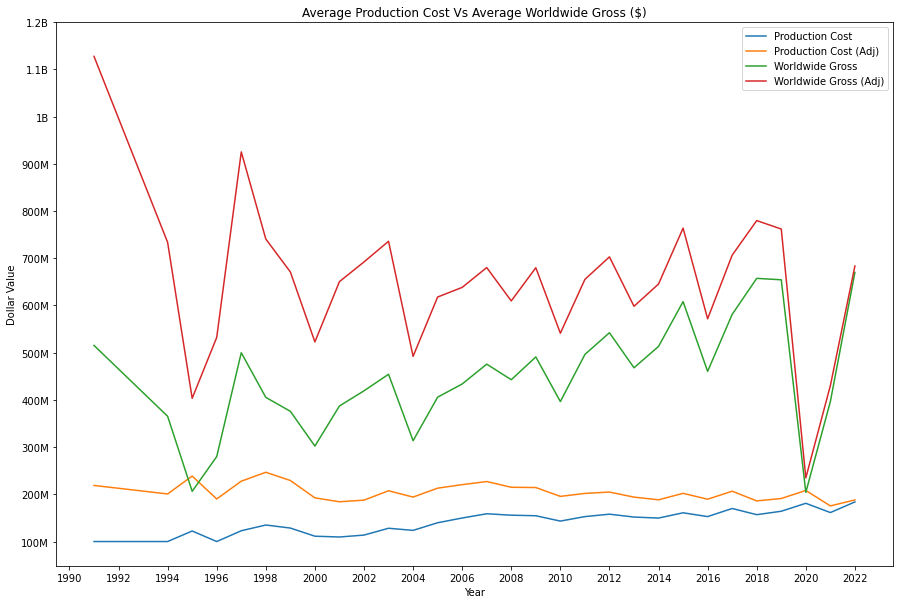

In [152]:
# Plot Budget Vs Revenue for $ value (US Revenue)
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(movie_averages.index.tolist(), movie_averages.iloc[:,0].tolist(), label='Production Cost')
ax.plot(movie_averages.index.tolist(), movie_averages.iloc[:,1].tolist(), label='Production Cost (Adj)')
ax.plot(movie_averages.index.tolist(), movie_averages.iloc[:,2].tolist(), label='Worldwide Gross')
ax.plot(movie_averages.index.tolist(), movie_averages.iloc[:,3].tolist(), label='Worldwide Gross (Adj)')

# ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
plt.xticks(np.arange(1990, 2024, 2))
plt.yticks(np.arange(100000000, 1300000000, 100000000))
ax.set_xlabel('Year')
ax.set_ylabel('Dollar Value')
ax.set_title('Average Production Cost Vs Average Worldwide Gross ($)')
ax.legend(loc='best')

plt.show()

### Top 10 and Lowest 10 Budgets Vs Revenue in US (Line plot analysis for Budget Vs Revenue)

In [153]:
# top_df = movies_df.sort_values(['production_cost'], ascending=False).groupby(['Year'])[['Year', 'title',
#          'production_cost','domestic_gross','worldwide_gross']].first().reset_index(drop=True)
# top_df = top_df.sort_values(['production_cost'])

top_df = movies_df.sort_values(['production_cost'], ascending=False).groupby(['production_cost'])[['Year', 'title',
         'production_cost','domestic_gross','worldwide_gross']].first().reset_index(drop=True)

# t1 = top_df.head(5)
# t2 = top_df.tail(5)
# # Drop index of bottom
# t2 = t2.reset_index(drop=True)
# # Stack t1 and t2
# top10_df = pd.concat([t1, t2], axis=0)

sliced_df = pd.DataFrame(top_df.groupby(pd.cut(top_df["production_cost"], np.arange(91000000, 400000000, 20000000))).first())
sliced_df = sliced_df[sliced_df['production_cost'].notna()]

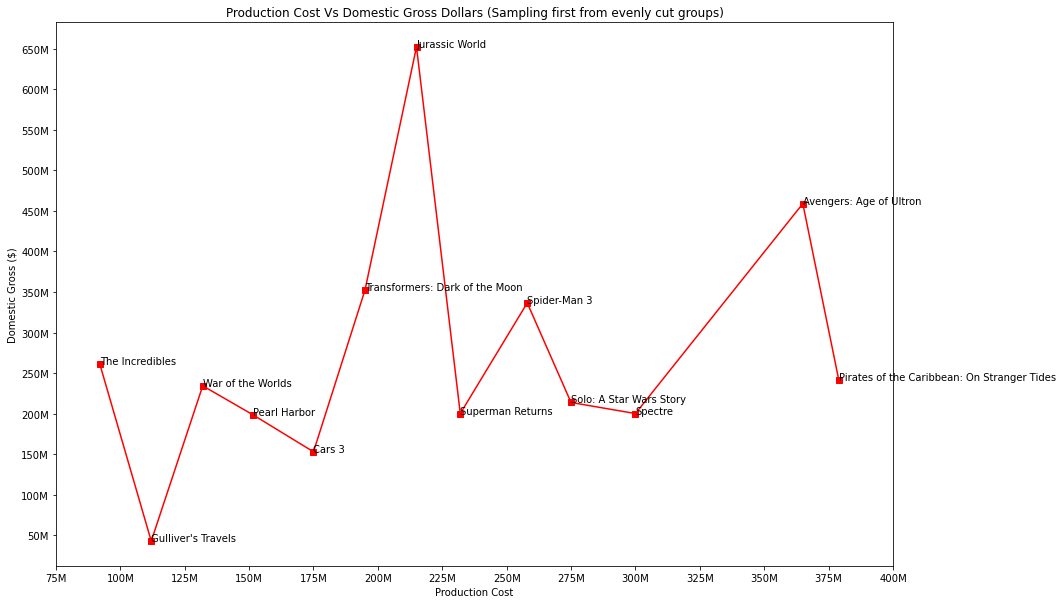

In [154]:
# Plot Production cost Vs Domestic Gross value 
x = sliced_df.iloc[:,2].tolist()
y = sliced_df.iloc[:,3].tolist()
text = sliced_df.iloc[:,1].tolist()

fig1, ax1 = plt.subplots()
fig1.set_figheight(7)
fig1.set_figwidth(10)

ax1.plot(x, y, label='Domestic', color='red', marker='s')
for i, txt in enumerate(text):
    ax1.annotate(txt, (x[i], y[i]))

ax1.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
ax1.xaxis.set_major_formatter(FuncFormatter(format_large_numbers))
plt.xticks(np.arange(75000000, 425000000, 25000000))
plt.yticks(np.arange(50000000, 700000000, 50000000))

ax1.set_xlabel('Production Cost')
ax1.set_ylabel('Domestic Gross ($)')
ax1.set_title('Production Cost Vs Domestic Gross Dollars (Sampling first from evenly cut groups)')

plt.show()

### Release Month vs Gross

In [ ]:
month_df = movies_df.groupby(['Month'])[['Month', 'domestic_gross']].mean().reset_index(drop=True)
month_df['Month Name'] = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']       
sorted_df = month_df.sort_values('domestic_gross', ascending=False)

In [ ]:
x_ax = sorted_df.iloc[:,2].tolist()
y_ax = sorted_df.iloc[:,1].tolist()
bar_colors = ['gold', 'tab:gray', 'lightcoral', 'teal', 'orchid', 'slateblue', 'lightseagreen', 
              'yellowgreen', 'tab:olive', 'violet', 'tab:brown', 'skyblue']

fig5, ax5 = plt.subplots()
fig5.set_figheight(6)
fig5.set_figwidth(9)

ax5.bar(x_ax, y_ax, color = 'teal')
ax5.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
plt.yticks(np.arange(0, 275000000, 25000000))

ax5.set_xlabel('Month of Release')
ax5.set_ylabel('Domestic Gross ($)')
ax5.set_title('Average Domestic Gross $ Vs Release Month')

plt.savefig("Images/bar1g.png")
plt.show()

### Top 10 movies for Domestic Gross (non-adjusted)

In [ ]:
sort1_df = movies_df.nlargest(10, ['domestic_gross'])
sort_title = sort1_df[['title', 'domestic_gross']]
sort_title = sort_title.rename(columns={'title': 'Title', 'domestic_gross':'Domestic Gross'})
sort_title = sort_title.style.set_properties(**{'text-align': 'left'})
sort_title

### Top 10 movies for Domestic Gross (adjusted)

In [ ]:
sort2_df = movies_df.nlargest(10, ['adjusted_domestic_gross'])
sort_title = sort1_df[['title', 'adjusted_domestic_gross']]
sort_title = sort_title.rename(columns={'title': 'Title', 'adjusted_domestic_gross':'Domestic Gross (Adj)'})
sort_title = sort_title.style.set_properties(**{'text-align': 'left'})
sort_title

### Highest Performing movies based on IMDB rating

In [ ]:
# Highest Performing movie of the year using IMDB Rating
max_year_df = movies_clean_df.sort_values(by = ["IMDB Rating"], ascending = False).groupby(["Year"]).first()
max_year_df.head()

In [ ]:
#Bar chart showing highest rated IMDB movie for each year
#loop through rows to extract max IMDB ratings
max_rating_list = []
max_titles_list = []

for column in max_year_df[["IMDB Rating"]]:
    rating = max_year_df[column]
    max_rating_list.append(rating.values)
    
for column in max_year_df[["title"]]:
    title = max_year_df[column]
    max_titles_list.append(title.values)
    
    
#print(max_rating_list)
#print(max_titles_list)

max_ratings = [8.6, 7.3, 6.2, 7. , 7.9, 6.7, 7.3, 8.5, 8.8, 8.8, 9. , 8. , 8.2,
       8. , 8.1, 9. , 8.3, 8.8, 7.7, 8.4, 8.2, 8.6, 8.2, 8.1, 8.4, 8.4,
       8.5, 7.4, 8.3, 8.4]

max_titles = ['1991 - Terminator 2: Judgment Day', '1994 - True Lies', '1995 - Waterworld',
       '1996 - The Hunchback of Notre Dame', '1997 - Titanic', '1998 - Armageddon', '1999 - Tarzan',
       '2000 - Gladiator', '2001 - The Lord of the Rings: The Fellowship of the Ring',
       '2002 - The Lord of the Rings: The Two Towers',
       '2003 - The Lord of the Rings: The Return of the King', '2004 - The Incredibles',
       '2005 - Batman Begins', '2006 - Casino Royale', '2007 - Ratatouille', '2008 - The Dark Knight',
       '2009 - Up', '2010 - Inception', '2011 - X-Men: First Class', '2012 - Django Unchained',
       '2013 - The Wolf of Wall Street', '2014 - Interstellar', '2015 - Inside Out', '2016 - Ben-Hur',
       '2017 - Coco', '2018 - Avengers: Infinity War', '2019 - The Lion King', '2020 -Onward',
       '2021 - Spider-Man: No Way Home', '2022 - Top Gun: Maverick']

#bar graph
plt.figure(figsize = (24, 7))
x_axis = np.arange(len(max_titles))
tick_locations = [value for value in x_axis]

plt.bar(max_titles, max_ratings, color = "blue", align = "center", alpha = 0.5)
plt.xticks(tick_locations, max_titles, fontsize = 17, rotation = "vertical")

# Set x and y limits
plt.xlim(-1, len(x_axis))
plt.ylim(0, max(max_ratings)+2)


#Graph Lables
plt.ylabel("IMDB Rating", fontsize = 15)
plt.title("Max IMDB Rating by Year", fontsize = 15)
plt.grid(True)